<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png"/>

<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center> 

# Text regression con transformers

En este notebook, aprenderemos a usar transformers para la tarea de text regression. 
Mientras que en las tareas de clasificación de textos, el objetivo del modelo es inferir a qué clase pertenece un texto, entre un conjunto de clases predefinidas, en **Regresión** el objetivo es asignar a un texto un valor numérico en un determinado rango, por ejemplo, valores en el intervalo [0, 1].

Utilizaremos el dataset proporcionado por la tarea [**Intimacy**](#https://codalab.lisn.upsaclay.fr/competitions/7096), cuyo objetivo es predecir el grado de intimidad de un tweet. El dataset es multilingüe porque incluye tweets de diferentes idiomas. 




Por favor, comprueba que estás utilizando GPU (Entorno de ejecución). Esta celda también te ayuda a comprobar si estás usando GPU y qué tipo de GPU estás utilizando: 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar  9 09:49:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Instalamos las librerías

In [ ]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━

## Data

Cargamos el conjunto de datos que consiste en una colección de tweets. Cada tweet se anota con una puntuación sobre su grado de intimidad. La tarea es predecir dicha puntuación para un tweet dado. 

In [ ]:
from google.colab import drive
from datasets import load_dataset

# mount your google drive
drive.mount('/content/drive')

# we load the dataset of sarcasm
path = "/content/drive/My Drive/Colab Notebooks/data/intimacy/"

data_files = {"train": path+"train-full.csv", 
              "test": path+"test_labeled.csv"}

dict_dataset = load_dataset("csv", data_files=data_files)
dict_dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 9491
    })
    test: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 3881
    })
})

In [ ]:
LANGUAGES = set(dict_dataset['train']['language'])
LANGUAGES

{'Chinese', 'English', 'French', 'Italian', 'Portuguese', 'Spanish'}

In [ ]:
aux = dict_dataset["train"].train_test_split(test_size=0.20, seed=42)
dict_dataset["validation"] = aux['test']
dict_dataset["train"] = aux['train']
del(aux)
dict_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 7592
    })
    test: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 3881
    })
    validation: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 1899
    })
})

Vamos a mostrar algunos tweets del training:

In [ ]:
import random

for i in range(5):
    index = random.randint(0,dict_dataset['train'].num_rows)
    print(dict_dataset['train'][index], y_train)
    print()
    

{'text': '上次說什麼來著，沒有軟棉棉的愛心了，軟棉棉的好像都發完了咧🤨 http', 'label': 2.4, 'language': 'Chinese'} [1.8, 2.25, 1.75, 2.0, 1.0, 3.25, 2.2, 5.0, 1.0, 1.6, 2.6, 1.25, 2.6, 1.0, 2.2, 3.4, 3.333333333333333, 1.75, 2.0, 3.2, 2.2, 1.4, 2.6, 1.0, 2.0, 1.0, 3.2, 1.0, 2.2, 2.0, 2.5, 1.25, 1.6, 1.75, 1.25, 2.8, 1.8, 2.6, 1.25, 3.75, 2.2, 2.2, 3.6, 2.6, 3.0, 1.6666666666666667, 1.25, 2.8, 2.5, 2.6, 2.2, 2.0, 2.6, 1.4, 1.4, 1.6, 3.2, 3.0, 1.0, 3.0, 1.0, 1.8, 3.0, 4.666666666666667, 2.0, 2.8, 2.0, 1.75, 1.0, 1.5, 3.4, 2.4, 1.0, 2.8, 2.8, 2.25, 3.4, 1.8, 1.6, 1.75, 2.8, 1.8, 2.0, 3.25, 1.6, 1.2, 2.8, 2.0, 1.2, 3.25, 1.25, 2.6, 1.75, 4.2, 3.5, 2.6, 1.0, 3.75, 1.75, 4.4, 2.8, 2.2, 1.8, 1.8, 2.4, 1.0, 2.8, 2.8, 1.0, 1.6, 3.0, 1.5, 2.0, 1.4, 1.0, 1.2, 2.6, 1.4, 1.6, 2.6, 1.25, 5.0, 1.6, 3.0, 2.4, 1.4, 1.0, 3.5, 2.8, 3.4, 1.0, 3.5, 1.25, 1.6, 1.25, 2.6, 1.75, 1.25, 1.5, 1.25, 2.0, 1.6, 3.6, 1.0, 1.4, 1.6, 3.4, 4.0, 1.5, 1.6, 3.4, 2.4, 1.0, 1.25, 2.8, 2.2, 3.2, 1.4, 1.0, 2.75, 1.75, 2.6, 1.6, 3.0, 2.2, 1.2, 1.8, 2.0, 1.

Guardamos las puntuaciones del grado de initmidad en cada split:

In [ ]:
#we gets the labels
y_train = dict_dataset['train']['label']
y_val = dict_dataset['validation']['label']
y_test = dict_dataset['test']['label']


## Modelo

Vamos a probar con distintos transformers:

In [ ]:
models= ['bert-base-multilingual-uncased', 
         'cardiffnlp/twitter-xlm-roberta-base', 
         'xlm-roberta-base', 
         'distilbert-base-multilingual-cased', 
         'microsoft/Multilingual-MiniLM-L12-H384']
MODEL_NAME=models[2] #0, 1, 2, 3, 4

### Tokenization

Debemos cargar el tokenizador asociado al modelo pre-entrenado que vayamos a usar. Este tokenizador nos permite transformar los textos de entrada al formato requerido para ajustar el modelo pre-entrenado a la tarea de regresión.

In [ ]:
from transformers import AutoTokenizer

if 'MiniLM' in MODEL_NAME:
    # we must load the tokenizer of XLM-R
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
else: 
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)



Es necesario conocer la longitud maxima de los textos en el dataset, para poder decidir cómo vamos a tokenizar los textos. 

In [ ]:
len_train_texts = [len(tokenizer(text).input_ids) for text in dict_dataset['train']['text']]

import pandas as pd
df=pd.Series(len_train_texts)
df.describe(percentiles=[0.25, 0.50, 0.75, 0.85, 0.90, 0.95, 0.99])


count    7592.000000
mean       21.380137
std        13.200095
min         3.000000
25%        13.000000
50%        19.000000
75%        27.000000
85%        32.000000
90%        35.000000
95%        42.000000
99%        77.000000
max       143.000000
dtype: float64

<AxesSubplot:>

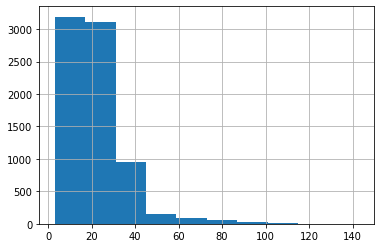

In [ ]:
df.hist()

Vemos que el 95% de los textos tienen una longitud menor o igual que 42 tokens. 

Tokenizamos los textos. El tokenizador prepará la entrada dependiendo del modelo transformer. Por ejemplo, daros cuenta que en el caso de RoBERTa, el tokenizador no añade el campo **token_type_ids**, como sí hace BERT.


In [ ]:
MAX_LEN = 42

def tokenize(examples):
    ## it applies the tokenzier on the dataset in its field text
    # we could add max_length = MAX_LENGHT, but in this case is not neccesary because MAX_LENTH is already 512, the maximum length allowed by the model
    return tokenizer(examples["text"], truncation=True, max_length=MAX_LEN, padding='max_length')


data_encodings=dict_dataset.map(tokenize, batched=True)
data_encodings


Map:   0%|          | 0/7592 [00:00<?, ? examples/s]

Map:   0%|          | 0/3881 [00:00<?, ? examples/s]

Map:   0%|          | 0/1899 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'language', 'input_ids', 'attention_mask'],
        num_rows: 7592
    })
    test: Dataset({
        features: ['text', 'label', 'language', 'input_ids', 'attention_mask'],
        num_rows: 3881
    })
    validation: Dataset({
        features: ['text', 'label', 'language', 'input_ids', 'attention_mask'],
        num_rows: 1899
    })
})

Borramos los campos que no se utilizarán durante el training. 

In [ ]:
data_encodings = data_encodings.remove_columns(['text','language'])
data_encodings

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 7592
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 3881
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1899
    })
})

Comprobamos que todas las secuencias tienen una longitud máxima de 42 tokens.

In [ ]:
for i in range(10):
    print(len(data_encodings['train'][i]['input_ids']), end=' ')


42 42 42 42 42 42 42 42 42 42 

Mostramos también el encoding del primer texto:

In [ ]:
print(dict_dataset['train'][0])
print(data_encodings['train'][0]['input_ids'])
# we can again to obtain the words that corresponde to each index
print(tokenizer.decode(data_encodings['train'][0]['input_ids']))


{'text': '@user 多了帽子跟抽繩 應該 是 這樣 吧', 'label': 1.8, 'language': 'Chinese'}
[0, 1374, 65918, 6, 53973, 189844, 3898, 20379, 231088, 6, 22020, 6, 354, 6, 18418, 6, 4502, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
<s> @user 多了帽子跟抽繩 應該 是 這樣 吧</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


Ya podemos cargar el modelo pre-enrenado. Para ello vamos a usar la clase **AutoModelForSequenceClassification**. En este caso, el número de labels será siempre 1, porque no es un tarea de clasificación, sino un problema de regresión. Este valor de 1, hace que la clase **AutoModelForSequenceClassification** utilice regresión liner y MSELoss para calcular la función de error automáticamente. 


In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = 1).to("cuda")


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

Debemos definir una función que calculará las métricas en cada epoch sobre el conjunto de validación. Usaremos métricas específicas para regresión.

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from scipy import stats

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    # loss metrics
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)
    # performance metrics
    r2 = r2_score(labels, logits)
    # pearson=stats.pearsonr(labels, logits)[0]

    # we return a dictionary with all metrics
    # return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape, "pearson": pearson}
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

Respecto a los parámetros:

In [ ]:
from transformers import TrainingArguments

NUM_EPOCHS = 3 

training_args = TrainingArguments(
    output_dir ='./results',          
    num_train_epochs = NUM_EPOCHS,     
    per_device_train_batch_size = 64, # 128 in the paper   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,  # 0.001 in the paper,
    logging_dir = './logs',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",  # steps in the paper
    save_strategy = "epoch",    # steps in the paper
    report_to = 'all',
) 

Ya estamos listos para entrenar el modelo:

In [ ]:
from transformers import Trainer

# Call the Trainer
trainer = Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = data_encodings['train'],         
    eval_dataset = data_encodings['validation'],          
    compute_metrics = compute_metrics_for_regression, 
)

# Train the model
trainer.train()


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7592
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 357
  Number of trainable parameters = 278044417


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,0.588586,0.588586,0.767194,0.632028,0.259599,30.957356
2,No log,0.457544,0.457544,0.676420,0.526285,0.424441,25.905563
3,No log,0.457090,0.457090,0.676084,0.523983,0.425012,25.636281


***** Running Evaluation *****
  Num examples = 1899
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-119
Configuration saved in ./results/checkpoint-119/config.json
Model weights saved in ./results/checkpoint-119/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1899
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-238
Configuration saved in ./results/checkpoint-238/config.json
Model weights saved in ./results/checkpoint-238/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1899
  Batch size = 20
Saving model checkpoint to ./results/checkpoint-357
Configuration saved in ./results/checkpoint-357/config.json
Model weights saved in ./results/checkpoint-357/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-119 (score: 0.7671935558319092).


TrainOutput(global_step=357, training_loss=0.6413277591309962, metrics={'train_runtime': 254.0209, 'train_samples_per_second': 89.662, 'train_steps_per_second': 1.405, 'total_flos': 491577482122272.0, 'train_loss': 0.6413277591309962, 'epoch': 3.0})

Evaluamos el modelo final sobre el conjunto de validación:

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1899
  Batch size = 20


{'eval_loss': 0.5885859131813049,
 'eval_mse': 0.5885859131813049,
 'eval_rmse': 0.7671935558319092,
 'eval_mae': 0.6320275068283081,
 'eval_r2': 0.2595991471765282,
 'eval_smape': 30.957356256582408,
 'eval_runtime': 4.5681,
 'eval_samples_per_second': 415.71,
 'eval_steps_per_second': 20.796,
 'epoch': 3.0}

## Evaluación


El trainer podría ser directamente evaluado sobre el conjunto test:

In [ ]:
trainer.eval_dataset = data_encodings['test']
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3881
  Batch size = 20


{'eval_loss': 0.7339295148849487,
 'eval_mse': 0.7339295744895935,
 'eval_rmse': 0.8566969037055969,
 'eval_mae': 0.7028743624687195,
 'eval_r2': 0.21190463970854256,
 'eval_smape': 33.36092300631281,
 'eval_runtime': 9.7416,
 'eval_samples_per_second': 398.394,
 'eval_steps_per_second': 20.017,
 'epoch': 3.0}


Aunque ya hemos obtenido una primera evaluación sobre el conjunto test, vamos a definir una función que pueda ser aplicada a cualquier texto para predecir su puntuación. Esta función nos permitirá obtener las prediciones para todo el conjunto test, y evaluar cada subconjunto (idioma) por separado. **texto en negrita**

In [ ]:
def get_prediction(text):
    inputs = tokenizer(text, max_length=MAX_LEN, padding="max_length", truncation=True, return_tensors="pt").to("cuda")
    outputs = model(**inputs)   
    return outputs[0].item()    

Aplicamos la función a todos los textos del test:

In [ ]:
y_pred=[get_prediction(text) for text in dict_dataset['test']['text']]
y_pred[:5]

[2.014519453048706,
 2.4424545764923096,
 2.286097288131714,
 2.533862352371216,
 3.097644329071045]

Definimos una función que nos permita imprimir las métricas en formato tabla:

In [ ]:
# from sklearn.metrics import explained_variance_score

def print_metrics(y_test, y_pred, lang=''):
    if lang:
        pass
    else:
        #         print("Final results on the whole test dataset")
        print('|   |MSE|RMSE|MAE|R2|SMAPE|PEARSON|')
        print('|---|---|---|---|---|---|---|')

    mse = mean_squared_error(y_test, y_pred)
    # print ("MSE: ", "{:.2f}".format(mse), end=', ')

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # print("RMSE: ", "{:.2f}".format(rmse), end=', ')
    
    mae = mean_absolute_error(y_test, y_pred)
    # print("MAE: ", "{:.2f}".format(mae), end=', ')

    r2 = r2_score(y_test, y_pred)
    # print("R2: ", "{:.2f}".format(r2), end=', ')

    diff=[label-pred for (label,pred) in zip(y_test,y_pred)]
    smape= 1/len(y_test) * np.sum(2 * np.abs(diff) / (np.abs(y_test) + np.abs(y_pred))*100)
    # print("SMAPE: ", "{:.2f}".format(smape), end=', ')

    pearson=stats.pearsonr(y_test, y_pred)[0]
    # print("PEARSON: ", "{:.2f}".format(pearson))
    # print()

    text_table=str('|')+lang+str('|') +"{:.2f}".format(mse) \
                +str('|')+"{:.2f}".format(rmse) \
                +str('|')+"{:.2f}".format(mae) \
                +str('|')+"{:.2f}".format(r2) \
                +str('|')+"{:.2f}".format(smape) \
                +str('|')+"{:.2f}".format(pearson) + str('|')

    print(text_table)
    # print()


In [ ]:
print_metrics(y_test, y_pred)

|   |MSE|RMSE|MAE|R2|SMAPE|PEARSON|
|---|---|---|---|---|---|---|
||0.73|0.86|0.70|0.21|33.36|0.51|


Ahora vamos a mostrar los resultados para cada idioma:

In [ ]:
print("Resultados finales para: ", MODEL_NAME)
# general results
print_metrics(y_test, y_pred)

for lang in sorted(LANGUAGES):
    test_language = dict_dataset['test'].filter(lambda example: example["language"]==lang)
    # print(lang, "number of instances instances in test dataset:", test_language.num_rows)
    # print("Example: ", test_language[0]['text'])
    y_test_lang=test_language['label']
    y_pred_lang=[get_prediction(text) for text in test_language['text']]
    print_metrics(y_test_lang, y_pred_lang, lang)
    

Resultados finales para:  xlm-roberta-base
|   |MSE|RMSE|MAE|R2|SMAPE|PEARSON|
|---|---|---|---|---|---|---|
||0.73|0.86|0.70|0.21|33.36|0.51|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|Chinese|0.48|0.69|0.56|0.39|25.17|0.66|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|English|0.55|0.74|0.61|0.26|30.62|0.60|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|French|0.65|0.81|0.67|0.17|32.58|0.56|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|Italian|0.55|0.74|0.62|0.22|32.26|0.60|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|Portuguese|0.65|0.81|0.68|0.11|31.70|0.54|


Filter:   0%|          | 0/3881 [00:00<?, ? examples/s]

|Spanish|0.58|0.76|0.62|0.38|28.31|0.66|


## Conclusions 

- ¿Qué modelo obtiene los mejores resultados?, ¿puedes ordenarlos de mejores a peores resultados? XLM-T > XLM-R > BERT > Distilbert > MiniLM
- ¿Qué idiomas muestrans los mejores resultados?. Chino, Inglés y Francés. 
